# Changes:

1. Use 1st ver UNET
2. Use the Augmentor Package to augment data
3. BCE loss + lovasz loss
4. Bilinear Upsampling
Best Val IOU: 0.8142 at epoch 176

Fine Tuning

1. Fined tuned for another 40 epochs and Best Val IOU: 0.8193
Use BCE + 0.1*lovasz loss. Leaderboard IOU: 0.797

2. Fine tuned for 80 epochs with more data aug and focal loss and best IOU is 0.8059

3. Fine tuned for 100 epochs with less data aug(only hflip), bce loss and lovasz loss.Best Val IOU: 0.8169 at epoch 28.

4. Fine tune with low salt images removed. Otherwise same set up as Run 1.


## Install required packages if running on google colab

In [1]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

In [2]:
cd salt_oil/

[WinError 2] The system cannot find the file specified: 'salt_oil/'
C:\work\code\repos\salt_oil


## Import required libs

In [3]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import Augmentor
import random
import PIL
% matplotlib inline
% load_ext autoreload
% autoreload 2

## Load Unet Modules

In [33]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch
from pytorch_unet.unet.resnet import *

In [5]:
## Setup data type based on whether GPU is enabled

In [6]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor

In [7]:
print(f'Data Type set to: {dtype}')

Data Type set to: <class 'torch.FloatTensor'>


## Create Global Variables

In [8]:
def init_global_variables():
    """initialize global variables such as db connection, logger etc."""
    global log
    log = get_logger('SaltNet')

In [9]:
init_global_variables()

In [10]:
class SaltDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, np_img, np_mask, df_depth, mean_img, out_size=101, out_ch=1, transform=None):
        """
        Args:
            data_dir (string): Path to the image files.
            train (bool): Load train or test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.np_img = np_img
        self.np_mask = np_mask.clip(0,1)
        self.df_depth = df_depth
        self.mean_img = mean_img
        self.out_size = out_size
        self.out_ch = out_ch
        self.transform = transform

    def __len__(self):
        return len(self.np_img)

    def __getitem__(self, idx):

        X_orig = self.np_img[idx]
        #X = X_orig - self.mean_img

        if self.np_mask is None:
            y = np.zeros((101,101,1))
        else:
            y = self.np_mask[idx]

        if self.transform:
            img_in = PIL.Image.fromarray(np.c_[np.tile(X_orig, 2), y*255])
            #img_in = PIL.Image.fromarray(np.tile(y, 3)*255)
            transformed = np.array(self.transform(img_in))
            X = np.clip(transformed[:,:,0:1]/255, 0., 1.) - self.mean_img
            y = np.clip(transformed[:,:,2:3]/255, 0., 1.)
        else:
            X = np.clip(X_orig/255, 0., 1.) - self.mean_img

        #print(X.dtype)
        
        X = np.moveaxis(X, -1,0)

        pad_size = self.out_size - X.shape[2]
        pad_first = pad_size//2
        pad_last = pad_size - pad_first
        X = np.pad(X, [(0, 0),(pad_first, pad_last), (pad_first, pad_last)], mode='reflect')
        #print(X.dtype)

        d = self.df_depth.iloc[idx,0]
        #id = self.df_depth.index[idx]
        #from boxx import g
        #g()
        X = torch.from_numpy(X).float().type(dtype)
        X = X.repeat(self.out_ch,1,1)
        y = transform.resize(y, (101, 101), mode='constant', preserve_range=True)
        y = torch.from_numpy(y).float().squeeze().type(dtype)

        return (X,y,d,idx)

In [11]:
class Pipeline_Salt(Augmentor.Pipeline):
    def __init__(self, source_directory=None, output_directory="output", save_format=None):
        super(Pipeline_Salt, self).__init__(source_directory, output_directory, save_format)

    def torch_transform(self):
        """
        Returns the pipeline as a function that can be used with torchvision.

        .. code-block:: python

            >>> import Augmentor
            >>> import torchvision
            >>> p = Augmentor.Pipeline()
            >>> p.rotate(probability=0.7, max_left_rotate=10, max_right_rotate=10)
            >>> p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
            >>> transforms = torchvision.transforms.Compose([
            >>>     p.torch_transform(),
            >>>     torchvision.transforms.ToTensor(),
            >>> ])

        :return: The pipeline as a function.
        """
        def _transform(image):
            for operation in self.operations:
                r = round(random.uniform(0, 1), 1)
                if r <= operation.probability:
                    if not isinstance(image, list):
                        image = [image]
                    image = operation.perform_operation(image)[0]

            return image

        return _transform

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [12]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

Try loading data from npy and pickle files...
Data loaded.


### Remove black images

In [13]:
#black_img_ids = (np_train_all.max((1,2,3))==0)

#np_train_all = np_train_all[~black_img_ids]
#np_train_all_mask = np_train_all_mask[~black_img_ids]

In [14]:
np_train_all.shape

(4000, 101, 101, 1)

### Remove images with all black masks

In [15]:
#black_mask_ids = (np_train_all_mask.max((1,2,3))==0)
#np_train_all = np_train_all[~black_mask_ids]
#np_train_all_mask = np_train_all_mask[~black_mask_ids]

In [16]:
np_train_all_mask.shape

(4000, 101, 101, 1)

### Train Val data split

In [17]:
#np_train_all = np.clip(np_train_all/255, 0, 1)
#X_test = np.clip(X_test/255, 0, 1)

In [18]:
np_train_all.shape

(4000, 101, 101, 1)

In [19]:
X_train_ids, X_val_ids = (
    train_test_split(np.arange(len(np_train_all)), 
                     test_size=0.20, 
                     random_state=42)
)

In [20]:
X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]

salt_pix_sum = (y_train/255).sum((1,2,3))
low_salt_img_masks = (salt_pix_sum>0) & (salt_pix_sum<154)
X_train = X_train[~low_salt_img_masks]
y_train = y_train[~low_salt_img_masks]


depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
    .loc[~low_salt_img_masks]
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': X_train_mean_img
}

### Remove images with low salt percent (<1.5%)

In [21]:
depth_train.shape

(3015, 1)

In [22]:
X_train.shape

(3015, 101, 101, 1)

In [23]:
y_train.shape

(3015, 101, 101, 1)

In [24]:
X_val.shape

(800, 101, 101, 1)

In [25]:
p = Pipeline_Salt()
#p.skew(probability=1, magnitude=0.5)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=5)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.0, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_by_size(probability=0.5, width=101, height=101, centre=False)


### Create a Train Dataloader

In [26]:
'''composed_tsfm = transforms.Compose([Rescale(scale='random', min_scale=1, max_scale=2),
                                    RandomCrop(101),
                                    Flip(orient='random')])'''

data_params = {'batch_size': 32,
               'shuffle': True,
               'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

sample = iter(dataloaders['train']).__next__()

assert sample[0].shape == torch.Size([data_params['batch_size'], 1, 128, 128])
assert sample[1].shape == torch.Size([data_params['batch_size'], 101, 101])
assert sample[2].shape == torch.Size([data_params['batch_size']])
assert sample[3].shape == torch.Size([data_params['batch_size']])

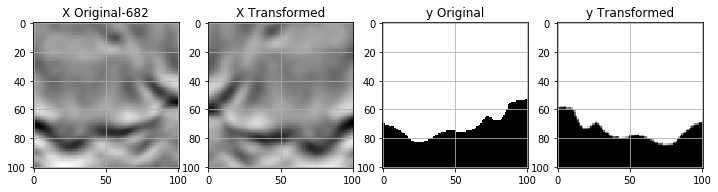

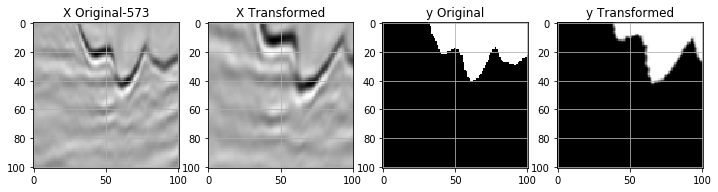

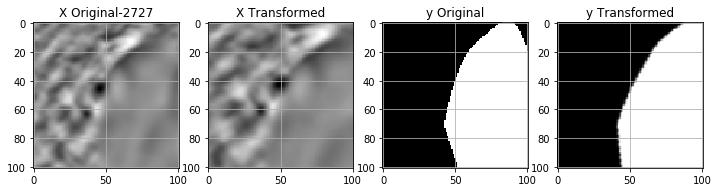

In [27]:
i = 0
for X_batch, y_batch, d_batch, X_id in dataloaders['train']:
    i+=1
    if i>3:
        break
    X_orig = X_train[X_id[0]].squeeze()/255
    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()[13:114,13:114] + X_train_mean_img.squeeze()
    y_orig = y_train[X_id[0]].squeeze()
    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm],
                       [f'X Original-{X_id[0]}', 'X Transformed', 'y Original', 'y Transformed'])

In [28]:
X_train.shape

(3015, 101, 101, 1)

### Create a Train Dataloader for sanity check

In [47]:
data_params = {'batch_size': 2,
               'shuffle': False,
               'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train[:8], y_train[:8], depth_train[:8],
                           X_train_mean_img, out_size=128, out_ch=1,
                           transform=None), **data_params)
                           #transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:8], y_val[:8], depth_val[:8], 
                           X_train_mean_img, out_size=128, out_ch=1), **data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}


In [35]:
t = iter(train_dataLoader).__next__()

In [36]:
X_batch, y_batch, d_batch, X_id = t

In [37]:
def train_model(model, dataloaders, criterion1, criterion2, optimizer, scheduler, model_save_name, other_data={}, 
                num_epochs=25, print_every=2, save_model_every=None, save_log_every=None, log=get_logger('SaltNet'), loss2_weight=0):
    #args = locals()
    #args = {k:v.shape if isinstance(v, (torch.Tensor, np.ndarray)) else v for k,v in args.items()}
    #args = {k:v.shape if isinstance(v, (torch.Tensor, np.ndarray)) else v for k,v in args.items()}
    log.info('Start Training...')
    #log.info('Passed parameters: {}'.format(args))

    start = time.time()

    if torch.cuda.is_available():
        model.cuda()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_model = None
    best_iou = 0.0
    all_losses = []
    iter_count = 0
    X_train = other_data['X_train']
    X_val = other_data['X_val']
    y_train = other_data['y_train']
    y_val = other_data['y_val']
    X_train_mean_img = other_data['X_train_mean_img']
    mask_cutoff = 0.

    for epoch in range(1, num_epochs+1):
        log.info('Epoch {}/{}'.format(epoch, num_epochs))
        log.info('-' * 20)
        if save_log_every is not None:
            if (epoch % save_log_every == 0):
                push_log_to_git()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_loss1 = []
            epoch_loss2 = []
            pred_vs_true_epoch = []

            for X_batch, y_batch, d_batch, X_id in dataloaders[phase]:
                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    #y_pred, y_mask_pred = model(X_batch)
                    y_pred = model(X_batch)
                    pred_vs_true_epoch.append([y_pred, y_batch])
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':                        
                        #from boxx import g
                        #g()
                        loss_1 = criterion1(y_pred, y_batch.float())      
                        loss_2 = loss2_weight * criterion2(y_pred, y_batch.float()) 

                        #print(f'loss_pix: {loss_pix}, loss_dice:{loss_dice}')
                        loss = loss_1 + loss_2
                        #loss = loss_pix
                        all_losses.append(loss.item())
                        epoch_loss1.append(loss_1.item())
                        epoch_loss2.append(loss_2.item())
                        
                        loss.backward()
                        optimizer.step()
                        iter_count += 1
                if (phase == 'train') & (iter_count % print_every == 0):
                    iou_batch = calc_mean_iou(y_pred.ge(mask_cutoff), y_batch.float())
                    iou_acc = calc_clf_accuracy(y_pred.ge(mask_cutoff), y_batch.float())

                    log.info('Batch Loss: {:.4f}, Epoch loss_1: {:.4f}, Epoch loss_2: {:.4f}, Batch IOU: {:.4f}, Batch Acc: {:.4f} at iter {}, epoch {}, Time: {}'.format(
                        np.mean(all_losses[-print_every:]), np.mean(epoch_loss1), np.mean(epoch_loss2), iou_batch, iou_acc, iter_count, epoch, timeSince(start))
                    )
                    #print(all_losses)
                    X_orig = X_train[X_id[0]].squeeze()/255
                    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()
                    X_tsfm = transform.resize(X_tsfm, (128, 128), mode='constant', preserve_range=True)
                    X_tsfm = X_tsfm[13:114,13:114] + X_train_mean_img.squeeze()
                    #X_tsfm = X_batch[0][X_batch[0].sum((1,2)).argmax()].squeeze().cpu().detach().numpy()[:101,:101] + X_train_mean_img.squeeze()

                    y_orig = y_train[X_id[0]].squeeze()
                    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
                    y_tsfm_pred =  y_pred[0].squeeze().gt(mask_cutoff)
                    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm, y_tsfm_pred],
                                       ['X Original', 'X Transformed', 'y Original', 'y Transformed', 'y Predicted'])

            y_pred_epoch = torch.cat([e[0] for e in pred_vs_true_epoch])
            y_true_epoch = torch.cat([e[1] for e in pred_vs_true_epoch])
            #from boxx import g
            #g()
            mean_iou_epoch = calc_mean_iou(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
            mean_acc_epoch = calc_clf_accuracy(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
            log.info('{} Mean IOU: {:.4f}, Mean Acc: {:.4f}, Best Val IOU: {:.4f} at epoch {}'.format(phase, mean_iou_epoch, mean_acc_epoch, best_iou, epoch))
            if phase == 'val' and mean_iou_epoch > best_iou:
                best_iou = mean_iou_epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                stats = {'best_iou': best_iou,
                         'all_losses': all_losses,
                         'iter_count': iter_count}
                log.info(save_model_state_to_chunks(epoch, copy.deepcopy(model.state_dict()),
                                                    copy.deepcopy(optimizer.state_dict()),
                                                    copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.'))
                best_model = (epoch, copy.deepcopy(model.state_dict()),
                                                    copy.deepcopy(optimizer.state_dict()),
                                                    copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.')
                log.info('Best Val Mean IOU so far: {}'.format(best_iou))
                # Visualize 1 val sample and predictions
                X_orig = X_val[X_id[0]].squeeze()/255
                y_orig = y_val[X_id[0]].squeeze()
                y_pred2 =  y_pred[0].squeeze().gt(mask_cutoff)
                plot_img_mask_pred([X_orig, y_orig, y_pred2],
                                   ['Val X Original', 'Val y Original', 'Val y Predicted'])
        if save_model_every is not None:
            if (epoch % save_model_every == 0) | (epoch == num_epochs-1):
                if (best_model is not None) and (best_iou>0.81):
                    log.info(save_model_state_to_chunks(*best_model))                
                    push_model_to_git(ckp_name=model_save_name)
                    best_model = None
                else:
                    log.info("Skip pushing model to git as there's no improvement")

    # load best model weights
    model.load_state_dict(best_model_wts)
    log.info('-' * 20)
    time_elapsed = time.time() - start
    log.info('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    log.info('Best val IOU: {:4f}'.format(best_iou))

    return model

## Train the model using a small data set to see if it can overfit

In [41]:
saltnet = resnet34unet()

Local ResNet


07/09/2018 23:47:20 - SaltNet - INFO - Start Training...
07/09/2018 23:47:20 - SaltNet - INFO - Epoch 1/100
07/09/2018 23:47:20 - SaltNet - INFO - --------------------
07/09/2018 23:47:28 - SaltNet - INFO - Batch Loss: 414.1915, Epoch loss_1: 414.1915, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.6973 at iter 2, epoch 1, Time: 0m 7s


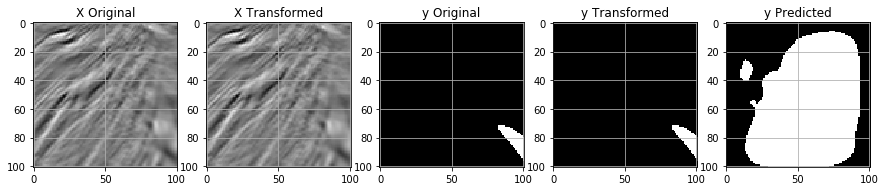

07/09/2018 23:47:36 - SaltNet - INFO - Batch Loss: 114.4229, Epoch loss_1: 264.3072, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.8060 at iter 4, epoch 1, Time: 0m 15s


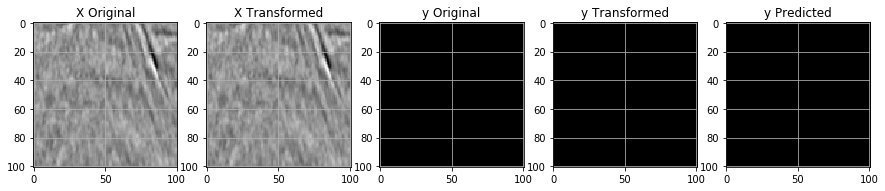

07/09/2018 23:47:36 - SaltNet - INFO - train Mean IOU: 0.5000, Mean Acc: 0.8052, Best Val IOU: 0.0000 at epoch 1
07/09/2018 23:47:39 - SaltNet - INFO - val Mean IOU: 0.0000, Mean Acc: 0.6078, Best Val IOU: 0.0000 at epoch 1
07/09/2018 23:47:39 - SaltNet - INFO - Epoch 2/100
07/09/2018 23:47:39 - SaltNet - INFO - --------------------
07/09/2018 23:47:46 - SaltNet - INFO - Batch Loss: 200.1189, Epoch loss_1: 200.1189, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.5851 at iter 6, epoch 2, Time: 0m 26s


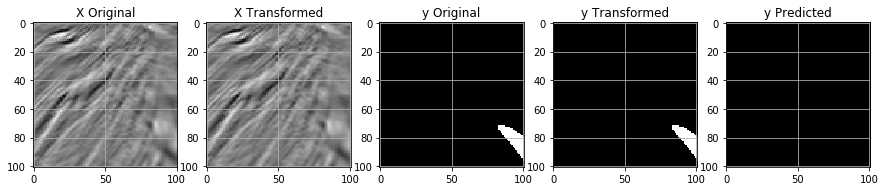

07/09/2018 23:47:54 - SaltNet - INFO - Batch Loss: 115.1156, Epoch loss_1: 157.6173, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.7831 at iter 8, epoch 2, Time: 0m 34s


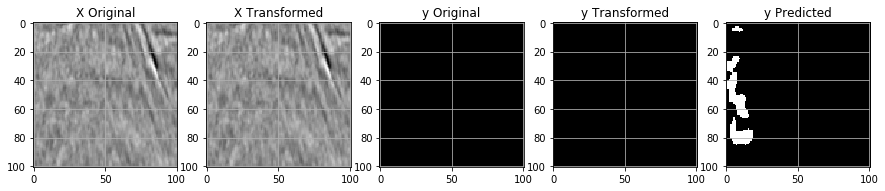

07/09/2018 23:47:55 - SaltNet - INFO - train Mean IOU: 0.2500, Mean Acc: 0.7277, Best Val IOU: 0.0000 at epoch 2
07/09/2018 23:47:58 - SaltNet - INFO - val Mean IOU: 0.3750, Mean Acc: 0.6106, Best Val IOU: 0.0000 at epoch 2
07/09/2018 23:47:58 - SaltNet - INFO - Model state is not saved as the out_file_prefix is None
07/09/2018 23:47:58 - SaltNet - INFO - Best Val Mean IOU so far: 0.375


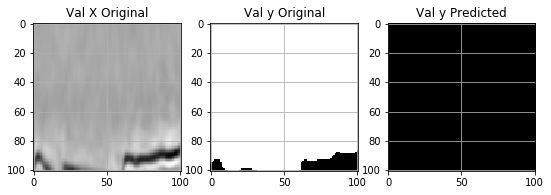

07/09/2018 23:47:59 - SaltNet - INFO - Epoch 3/100
07/09/2018 23:47:59 - SaltNet - INFO - --------------------
07/09/2018 23:48:06 - SaltNet - INFO - Batch Loss: 181.1472, Epoch loss_1: 181.1472, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.7452 at iter 10, epoch 3, Time: 0m 45s


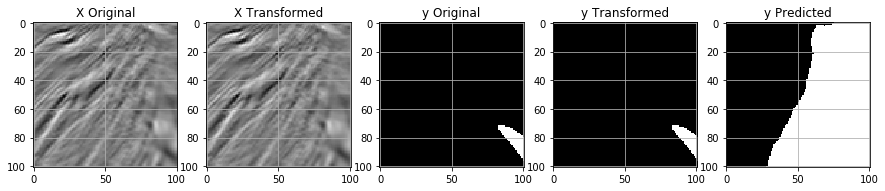

07/09/2018 23:48:13 - SaltNet - INFO - Batch Loss: 17.9956, Epoch loss_1: 99.5714, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.7809 at iter 12, epoch 3, Time: 0m 52s


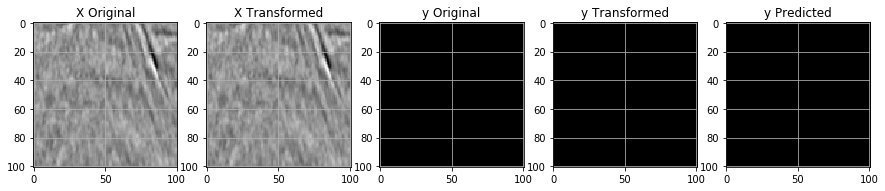

07/09/2018 23:48:14 - SaltNet - INFO - train Mean IOU: 0.3750, Mean Acc: 0.8093, Best Val IOU: 0.3750 at epoch 3
07/09/2018 23:48:17 - SaltNet - INFO - val Mean IOU: 0.3750, Mean Acc: 0.6106, Best Val IOU: 0.3750 at epoch 3
07/09/2018 23:48:17 - SaltNet - INFO - Epoch 4/100
07/09/2018 23:48:17 - SaltNet - INFO - --------------------
07/09/2018 23:48:24 - SaltNet - INFO - Batch Loss: 104.7061, Epoch loss_1: 104.7061, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.6741 at iter 14, epoch 4, Time: 1m 3s


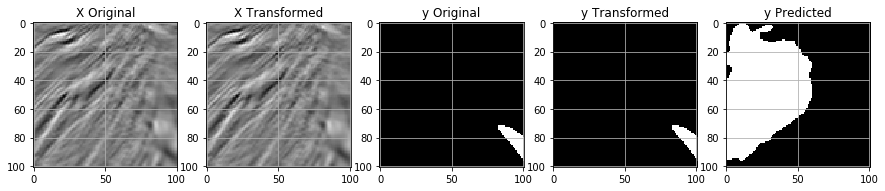

07/09/2018 23:48:31 - SaltNet - INFO - Batch Loss: 16.1046, Epoch loss_1: 60.4053, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.8269 at iter 16, epoch 4, Time: 1m 10s


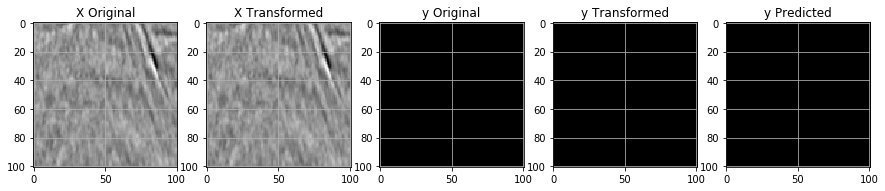

07/09/2018 23:48:31 - SaltNet - INFO - train Mean IOU: 0.2500, Mean Acc: 0.7388, Best Val IOU: 0.3750 at epoch 4
07/09/2018 23:48:34 - SaltNet - INFO - val Mean IOU: 0.3750, Mean Acc: 0.6106, Best Val IOU: 0.3750 at epoch 4
07/09/2018 23:48:34 - SaltNet - INFO - Epoch 5/100
07/09/2018 23:48:34 - SaltNet - INFO - --------------------
07/09/2018 23:48:41 - SaltNet - INFO - Batch Loss: 32.6330, Epoch loss_1: 32.6330, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.7605 at iter 18, epoch 5, Time: 1m 20s


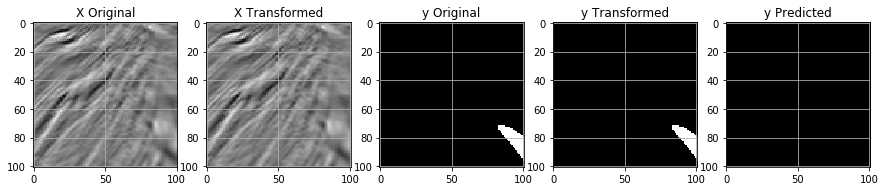

07/09/2018 23:48:49 - SaltNet - INFO - Batch Loss: 7.3416, Epoch loss_1: 19.9873, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.8209 at iter 20, epoch 5, Time: 1m 29s


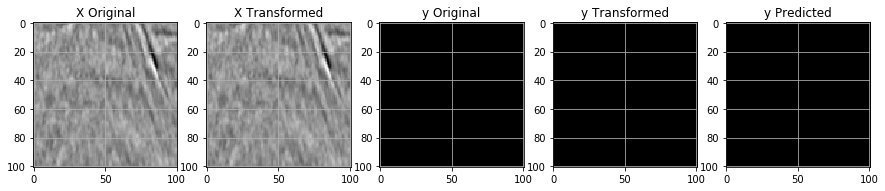

07/09/2018 23:48:50 - SaltNet - INFO - train Mean IOU: 0.2500, Mean Acc: 0.8420, Best Val IOU: 0.3750 at epoch 5
07/09/2018 23:48:53 - SaltNet - INFO - val Mean IOU: 0.0250, Mean Acc: 0.6181, Best Val IOU: 0.3750 at epoch 5
07/09/2018 23:48:53 - SaltNet - INFO - Epoch 6/100
07/09/2018 23:48:53 - SaltNet - INFO - --------------------
07/09/2018 23:49:00 - SaltNet - INFO - Batch Loss: 14.2887, Epoch loss_1: 14.2887, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.9524 at iter 22, epoch 6, Time: 1m 40s


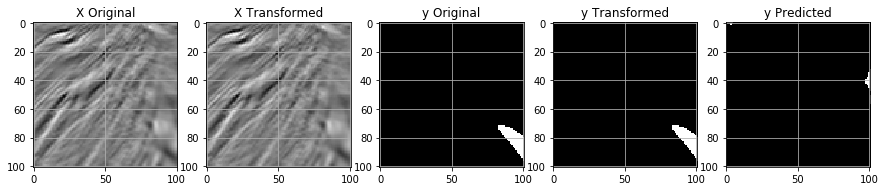

07/09/2018 23:49:08 - SaltNet - INFO - Batch Loss: 41.4823, Epoch loss_1: 27.8855, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.8215 at iter 24, epoch 6, Time: 1m 47s


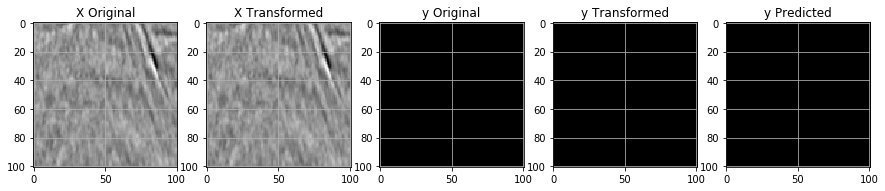

07/09/2018 23:49:09 - SaltNet - INFO - train Mean IOU: 0.1250, Mean Acc: 0.8010, Best Val IOU: 0.3750 at epoch 6
07/09/2018 23:49:12 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3905, Best Val IOU: 0.3750 at epoch 6
07/09/2018 23:49:12 - SaltNet - INFO - Epoch 7/100
07/09/2018 23:49:12 - SaltNet - INFO - --------------------
07/09/2018 23:49:19 - SaltNet - INFO - Batch Loss: 12.6681, Epoch loss_1: 12.6681, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.9416 at iter 26, epoch 7, Time: 1m 58s


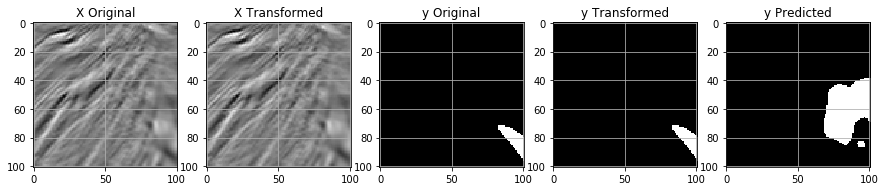

07/09/2018 23:49:27 - SaltNet - INFO - Batch Loss: 16.4228, Epoch loss_1: 14.5454, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.8081 at iter 28, epoch 7, Time: 2m 6s


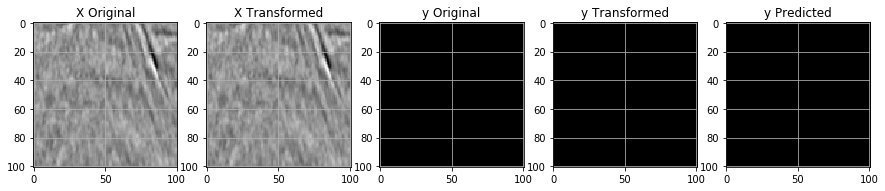

07/09/2018 23:49:27 - SaltNet - INFO - train Mean IOU: 0.3000, Mean Acc: 0.8927, Best Val IOU: 0.3750 at epoch 7
07/09/2018 23:49:30 - SaltNet - INFO - val Mean IOU: 0.3750, Mean Acc: 0.6106, Best Val IOU: 0.3750 at epoch 7
07/09/2018 23:49:30 - SaltNet - INFO - Epoch 8/100
07/09/2018 23:49:30 - SaltNet - INFO - --------------------
07/09/2018 23:49:38 - SaltNet - INFO - Batch Loss: 33.4290, Epoch loss_1: 33.4290, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.9901 at iter 30, epoch 8, Time: 2m 17s


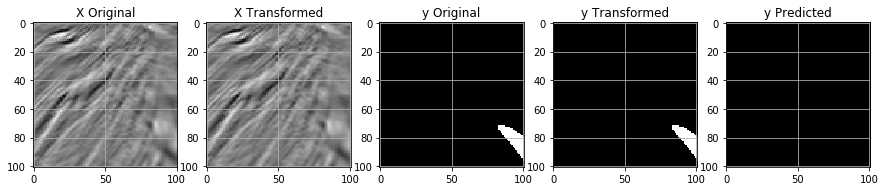

07/09/2018 23:49:45 - SaltNet - INFO - Batch Loss: 1.7001, Epoch loss_1: 17.5645, Epoch loss_2: 0.0000, Batch IOU: 0.8000, Batch Acc: 0.9559 at iter 32, epoch 8, Time: 2m 24s


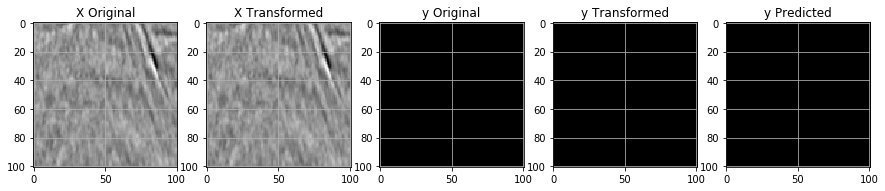

07/09/2018 23:49:46 - SaltNet - INFO - train Mean IOU: 0.4500, Mean Acc: 0.9150, Best Val IOU: 0.3750 at epoch 8
07/09/2018 23:49:49 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3909, Best Val IOU: 0.3750 at epoch 8
07/09/2018 23:49:49 - SaltNet - INFO - Epoch 9/100
07/09/2018 23:49:49 - SaltNet - INFO - --------------------
07/09/2018 23:49:56 - SaltNet - INFO - Batch Loss: 6.1523, Epoch loss_1: 6.1523, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.8919 at iter 34, epoch 9, Time: 2m 35s


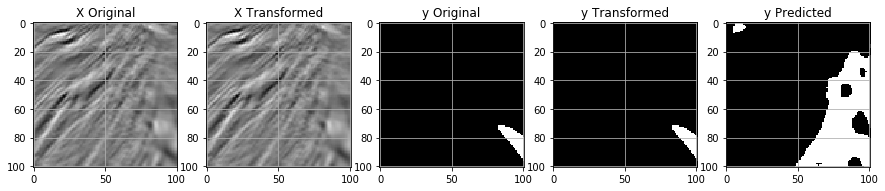

07/09/2018 23:50:06 - SaltNet - INFO - Batch Loss: 5.7217, Epoch loss_1: 5.9370, Epoch loss_2: 0.0000, Batch IOU: 0.1500, Batch Acc: 0.8878 at iter 36, epoch 9, Time: 2m 45s


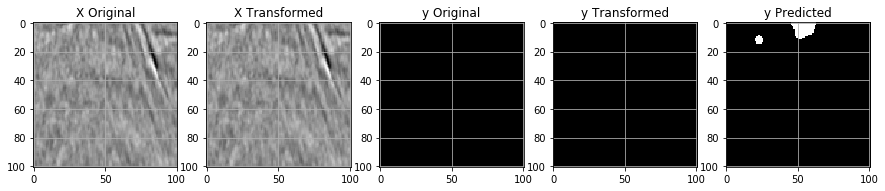

07/09/2018 23:50:07 - SaltNet - INFO - train Mean IOU: 0.2625, Mean Acc: 0.9091, Best Val IOU: 0.3750 at epoch 9
07/09/2018 23:50:11 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3898, Best Val IOU: 0.3750 at epoch 9
07/09/2018 23:50:11 - SaltNet - INFO - Epoch 10/100
07/09/2018 23:50:11 - SaltNet - INFO - --------------------
07/09/2018 23:50:18 - SaltNet - INFO - Batch Loss: 2.6161, Epoch loss_1: 2.6161, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.9532 at iter 38, epoch 10, Time: 2m 58s


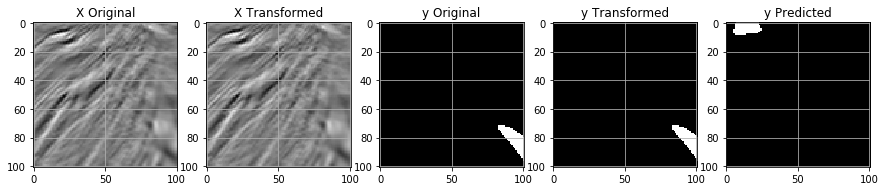

07/09/2018 23:50:26 - SaltNet - INFO - Batch Loss: 7.3710, Epoch loss_1: 4.9935, Epoch loss_2: 0.0000, Batch IOU: 0.7000, Batch Acc: 0.9364 at iter 40, epoch 10, Time: 3m 6s


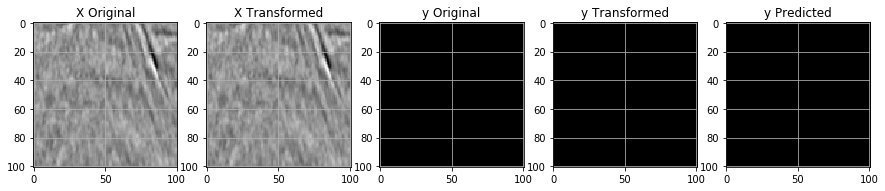

07/09/2018 23:50:27 - SaltNet - INFO - train Mean IOU: 0.3375, Mean Acc: 0.9392, Best Val IOU: 0.3750 at epoch 10
07/09/2018 23:50:31 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.3912, Best Val IOU: 0.3750 at epoch 10
07/09/2018 23:50:31 - SaltNet - INFO - Epoch 11/100
07/09/2018 23:50:31 - SaltNet - INFO - --------------------
07/09/2018 23:50:39 - SaltNet - INFO - Batch Loss: 1.6766, Epoch loss_1: 1.6766, Epoch loss_2: 0.0000, Batch IOU: 0.0500, Batch Acc: 0.9929 at iter 42, epoch 11, Time: 3m 18s


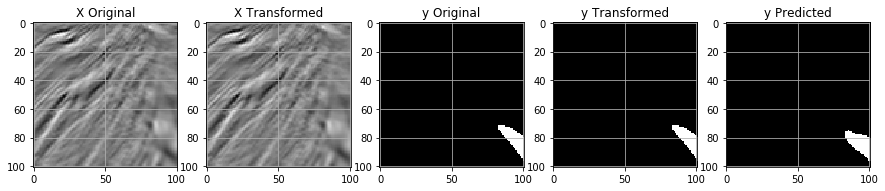

07/09/2018 23:50:47 - SaltNet - INFO - Batch Loss: 0.4530, Epoch loss_1: 1.0648, Epoch loss_2: 0.0000, Batch IOU: 0.9500, Batch Acc: 0.9879 at iter 44, epoch 11, Time: 3m 26s


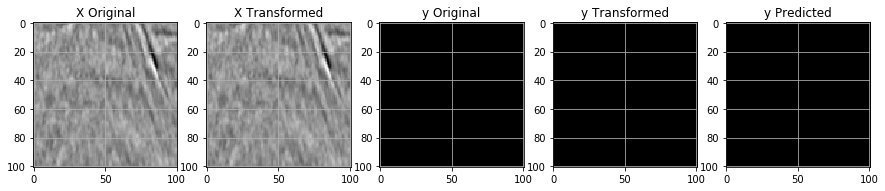

07/09/2018 23:50:47 - SaltNet - INFO - train Mean IOU: 0.5000, Mean Acc: 0.9802, Best Val IOU: 0.3750 at epoch 11
07/09/2018 23:50:51 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.4180, Best Val IOU: 0.3750 at epoch 11
07/09/2018 23:50:51 - SaltNet - INFO - Epoch 12/100
07/09/2018 23:50:51 - SaltNet - INFO - --------------------
07/09/2018 23:51:00 - SaltNet - INFO - Batch Loss: 0.9565, Epoch loss_1: 0.9565, Epoch loss_2: 0.0000, Batch IOU: 0.6000, Batch Acc: 0.9940 at iter 46, epoch 12, Time: 3m 39s


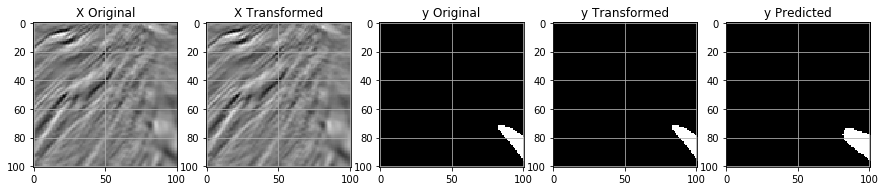

07/09/2018 23:51:09 - SaltNet - INFO - Batch Loss: 1.5208, Epoch loss_1: 1.2387, Epoch loss_2: 0.0000, Batch IOU: 0.9500, Batch Acc: 0.9842 at iter 48, epoch 12, Time: 3m 48s


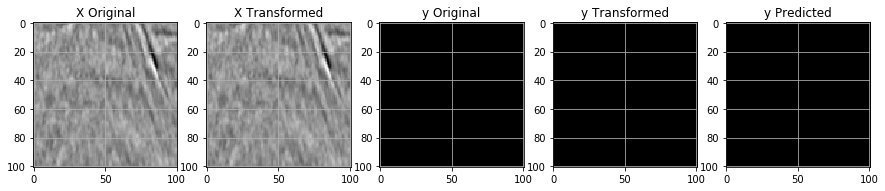

07/09/2018 23:51:10 - SaltNet - INFO - train Mean IOU: 0.6875, Mean Acc: 0.9752, Best Val IOU: 0.3750 at epoch 12
07/09/2018 23:51:13 - SaltNet - INFO - val Mean IOU: 0.2625, Mean Acc: 0.5655, Best Val IOU: 0.3750 at epoch 12
07/09/2018 23:51:13 - SaltNet - INFO - Epoch 13/100
07/09/2018 23:51:13 - SaltNet - INFO - --------------------
07/09/2018 23:51:22 - SaltNet - INFO - Batch Loss: 0.9897, Epoch loss_1: 0.9897, Epoch loss_2: 0.0000, Batch IOU: 0.7000, Batch Acc: 0.9961 at iter 50, epoch 13, Time: 4m 1s


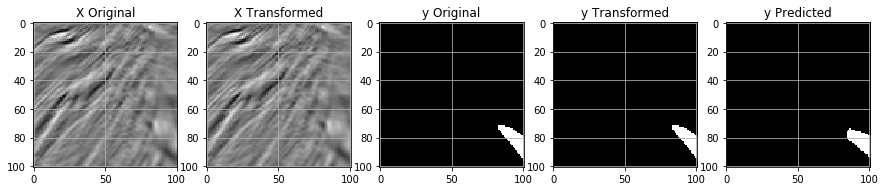

07/09/2018 23:51:31 - SaltNet - INFO - Batch Loss: 0.5547, Epoch loss_1: 0.7722, Epoch loss_2: 0.0000, Batch IOU: 0.9500, Batch Acc: 0.9881 at iter 52, epoch 13, Time: 4m 10s


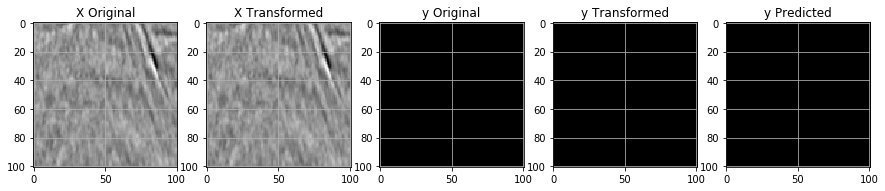

07/09/2018 23:51:31 - SaltNet - INFO - train Mean IOU: 0.7000, Mean Acc: 0.9813, Best Val IOU: 0.3750 at epoch 13
07/09/2018 23:51:36 - SaltNet - INFO - val Mean IOU: 0.3375, Mean Acc: 0.6189, Best Val IOU: 0.3750 at epoch 13
07/09/2018 23:51:36 - SaltNet - INFO - Epoch 14/100
07/09/2018 23:51:36 - SaltNet - INFO - --------------------
07/09/2018 23:51:47 - SaltNet - INFO - Batch Loss: 0.8707, Epoch loss_1: 0.8707, Epoch loss_2: 0.0000, Batch IOU: 0.6000, Batch Acc: 0.9957 at iter 54, epoch 14, Time: 4m 26s


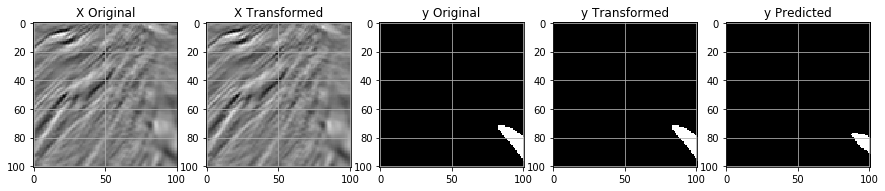

07/09/2018 23:51:58 - SaltNet - INFO - Batch Loss: 0.2682, Epoch loss_1: 0.5695, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9903 at iter 56, epoch 14, Time: 4m 37s


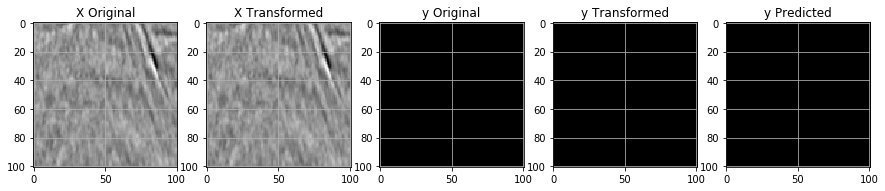

07/09/2018 23:51:58 - SaltNet - INFO - train Mean IOU: 0.8250, Mean Acc: 0.9854, Best Val IOU: 0.3750 at epoch 14
07/09/2018 23:52:03 - SaltNet - INFO - val Mean IOU: 0.2750, Mean Acc: 0.6329, Best Val IOU: 0.3750 at epoch 14
07/09/2018 23:52:03 - SaltNet - INFO - Epoch 15/100
07/09/2018 23:52:03 - SaltNet - INFO - --------------------
07/09/2018 23:52:13 - SaltNet - INFO - Batch Loss: 0.7305, Epoch loss_1: 0.7305, Epoch loss_2: 0.0000, Batch IOU: 0.6500, Batch Acc: 0.9959 at iter 58, epoch 15, Time: 4m 52s


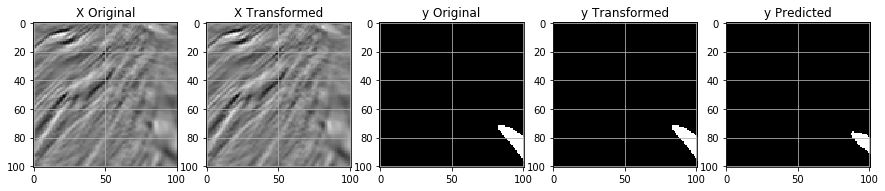

07/09/2018 23:52:24 - SaltNet - INFO - Batch Loss: 0.2257, Epoch loss_1: 0.4781, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9913 at iter 60, epoch 15, Time: 5m 3s


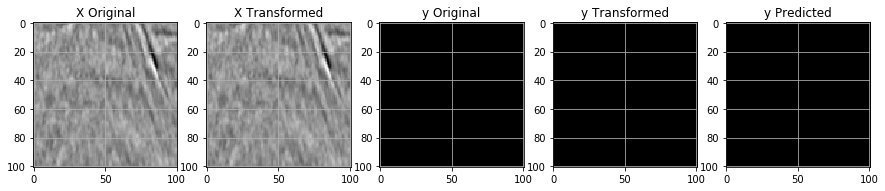

07/09/2018 23:52:25 - SaltNet - INFO - train Mean IOU: 0.8375, Mean Acc: 0.9866, Best Val IOU: 0.3750 at epoch 15
07/09/2018 23:52:31 - SaltNet - INFO - val Mean IOU: 0.3125, Mean Acc: 0.6127, Best Val IOU: 0.3750 at epoch 15
07/09/2018 23:52:31 - SaltNet - INFO - Epoch 16/100
07/09/2018 23:52:31 - SaltNet - INFO - --------------------
07/09/2018 23:52:43 - SaltNet - INFO - Batch Loss: 0.5633, Epoch loss_1: 0.5633, Epoch loss_2: 0.0000, Batch IOU: 0.8000, Batch Acc: 0.9973 at iter 62, epoch 16, Time: 5m 22s


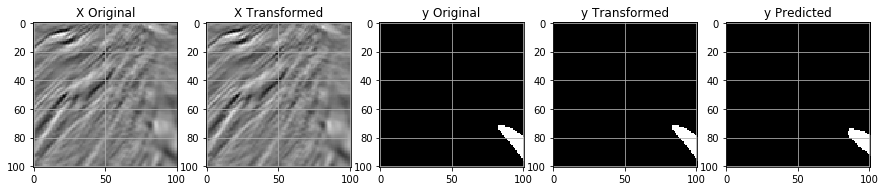

07/09/2018 23:52:55 - SaltNet - INFO - Batch Loss: 0.1626, Epoch loss_1: 0.3630, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9934 at iter 64, epoch 16, Time: 5m 35s


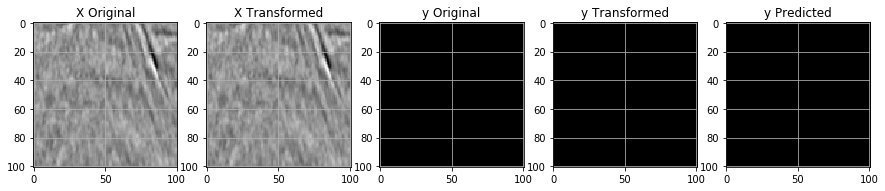

07/09/2018 23:52:56 - SaltNet - INFO - train Mean IOU: 0.8875, Mean Acc: 0.9885, Best Val IOU: 0.3750 at epoch 16
07/09/2018 23:53:03 - SaltNet - INFO - val Mean IOU: 0.2625, Mean Acc: 0.6083, Best Val IOU: 0.3750 at epoch 16
07/09/2018 23:53:03 - SaltNet - INFO - Epoch 17/100
07/09/2018 23:53:03 - SaltNet - INFO - --------------------
07/09/2018 23:53:16 - SaltNet - INFO - Batch Loss: 0.3689, Epoch loss_1: 0.3689, Epoch loss_2: 0.0000, Batch IOU: 0.8000, Batch Acc: 0.9972 at iter 66, epoch 17, Time: 5m 56s


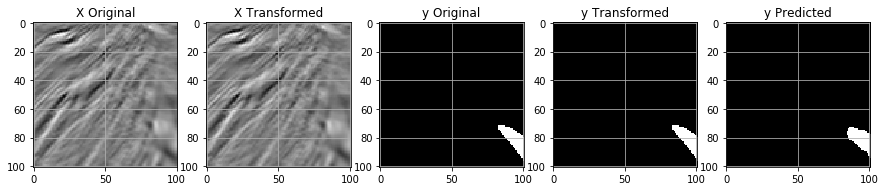

07/09/2018 23:53:35 - SaltNet - INFO - Batch Loss: 0.1082, Epoch loss_1: 0.2385, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9947 at iter 68, epoch 17, Time: 6m 14s


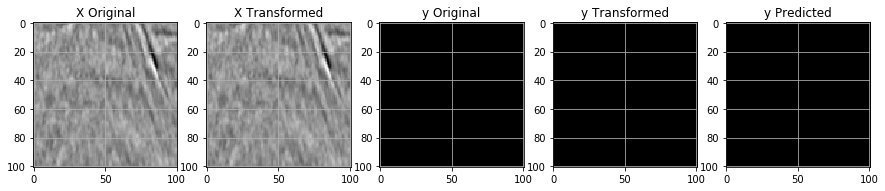

07/09/2018 23:53:37 - SaltNet - INFO - train Mean IOU: 0.9125, Mean Acc: 0.9904, Best Val IOU: 0.3750 at epoch 17
07/09/2018 23:53:45 - SaltNet - INFO - val Mean IOU: 0.2875, Mean Acc: 0.6755, Best Val IOU: 0.3750 at epoch 17
07/09/2018 23:53:45 - SaltNet - INFO - Epoch 18/100
07/09/2018 23:53:45 - SaltNet - INFO - --------------------
07/09/2018 23:54:00 - SaltNet - INFO - Batch Loss: 0.2346, Epoch loss_1: 0.2346, Epoch loss_2: 0.0000, Batch IOU: 0.8000, Batch Acc: 0.9973 at iter 70, epoch 18, Time: 6m 39s


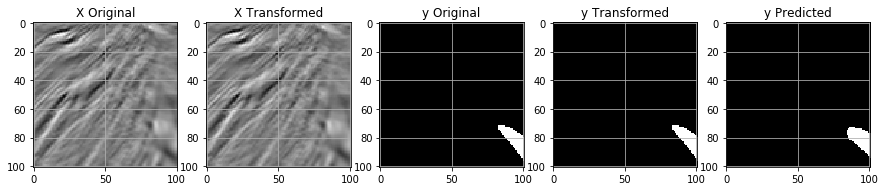

07/09/2018 23:54:14 - SaltNet - INFO - Batch Loss: 0.0724, Epoch loss_1: 0.1535, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9957 at iter 72, epoch 18, Time: 6m 53s


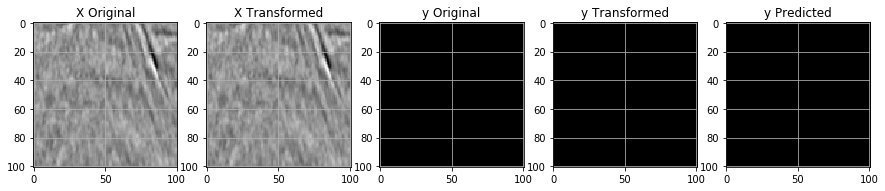

07/09/2018 23:54:15 - SaltNet - INFO - train Mean IOU: 0.9125, Mean Acc: 0.9922, Best Val IOU: 0.3750 at epoch 18
07/09/2018 23:54:20 - SaltNet - INFO - val Mean IOU: 0.2875, Mean Acc: 0.6927, Best Val IOU: 0.3750 at epoch 18
07/09/2018 23:54:20 - SaltNet - INFO - Epoch 19/100
07/09/2018 23:54:20 - SaltNet - INFO - --------------------
07/09/2018 23:54:32 - SaltNet - INFO - Batch Loss: 0.1746, Epoch loss_1: 0.1746, Epoch loss_2: 0.0000, Batch IOU: 0.8000, Batch Acc: 0.9972 at iter 74, epoch 19, Time: 7m 11s


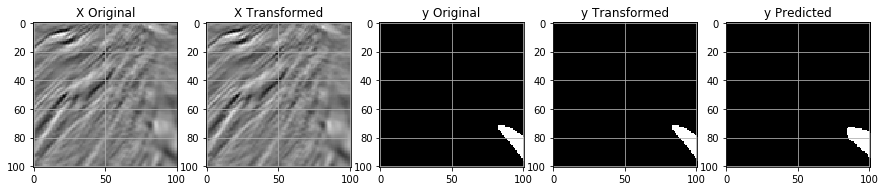

07/09/2018 23:54:45 - SaltNet - INFO - Batch Loss: 0.0514, Epoch loss_1: 0.1130, Epoch loss_2: 0.0000, Batch IOU: 1.0000, Batch Acc: 0.9962 at iter 76, epoch 19, Time: 7m 24s


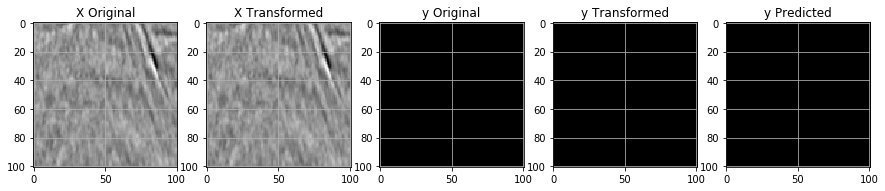

07/09/2018 23:54:46 - SaltNet - INFO - train Mean IOU: 0.9250, Mean Acc: 0.9929, Best Val IOU: 0.3750 at epoch 19
07/09/2018 23:54:51 - SaltNet - INFO - val Mean IOU: 0.3375, Mean Acc: 0.6938, Best Val IOU: 0.3750 at epoch 19
07/09/2018 23:54:51 - SaltNet - INFO - Epoch 20/100
07/09/2018 23:54:51 - SaltNet - INFO - --------------------


In [ ]:
#saltnet = resnet34unet(in_ch=3, bilinear=False, pretrained=False)

loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()

optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

model_save_name = None

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=2, save_model_every=None, save_log_every=None, log=log)

## Train the full with full dataset

In [94]:
log.info('Fine tune with lavasz loss set to 0.1, remove low salt images (less than 1.5%)')

07/09/2018 07:10:21 - SaltNet - INFO - Fine tune with lavasz loss set to 0.1, remove low salt images (less than 1.5%)


In [95]:
log.info(model_info)

07/09/2018 07:10:25 - SaltNet - INFO -  Remvoe los salt images (less than 1.5% salt)
p = Pipeline_Salt()
#p.skew(probability=1, magnitude=0.5)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=5)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.0, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_by_size(probability=0.5, width=101, height=101, centre=False)


loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()

# fine tuning
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
if torch.cuda.is_available():
  saltnet.cuda()
model_file_suffix = "../salt_net/Unet_bce_loss_lovasz_loss_2018_09_05_23_54_40.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])
optimizer = torch.optim.Adam(s

In [ ]:
model_info = ''' Remvoe los salt images (less than 1.5% salt)
p = Pipeline_Salt()
#p.skew(probability=1, magnitude=0.5)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=5)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.0, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_by_size(probability=0.5, width=101, height=101, centre=False)


loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()

# fine tuning
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
if torch.cuda.is_available():
  saltnet.cuda()
model_file_suffix = "../salt_net/Unet_bce_loss_lovasz_loss_2018_09_05_23_54_40.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
optimizer.load_state_dict(model_state_dict['optimizer'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler.load_state_dict(model_state_dict['scheduler'])

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_{get_current_time_as_fname()}.ckp'
#model_save_name = None
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=50, save_model_every=20, save_log_every=2, log=log, loss2_weight=0.1)'''

In [ ]:
p = Pipeline_Salt()
#p.skew(probability=1, magnitude=0.5)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=5)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.0, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_by_size(probability=0.5, width=101, height=101, centre=False)

In [ ]:
data_params = {'batch_size': 32,
               'shuffle': True,
               'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

In [ ]:
loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()

Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling


07/09/2018 07:10:47 - SaltNet - INFO - ../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_2018_09_07_17_10_47.ckp
07/09/2018 07:10:47 - SaltNet - INFO - Start Training...
07/09/2018 07:10:47 - SaltNet - INFO - Epoch 1/100
07/09/2018 07:10:47 - SaltNet - INFO - --------------------
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
07/09/2018 07:12:09 - SaltNet - INFO - Batch Loss: 0.1768, Epoch loss_1: 0.1464, Epoch loss_2: 0.0304, Batch IOU: 0.8469, Batch Acc: 0.9550 at iter 50, epoch 1, Time: 1m 22s


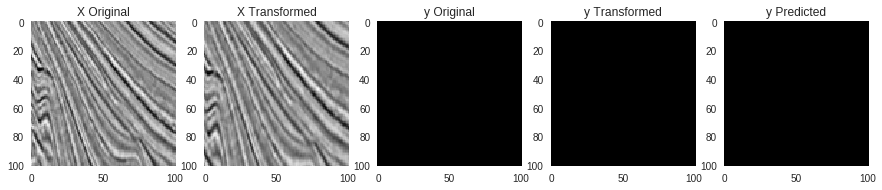

07/09/2018 07:13:23 - SaltNet - INFO - train Mean IOU: 0.7814, Mean Acc: 0.9386, Best Val IOU: 0.0000 at epoch 1
07/09/2018 07:13:35 - SaltNet - INFO - val Mean IOU: 0.8128, Mean Acc: 0.9547, Best Val IOU: 0.0000 at epoch 1
07/09/2018 07:13:36 - SaltNet - INFO - ['../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_2018_09_07_17_10_47.ckp-chunk-1-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_2018_09_07_17_10_47.ckp-chunk-2-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_2018_09_07_17_10_47.ckp-chunk-3-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_2018_09_07_17_10_47.ckp-chunk-4-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_2018_09_07_17_10_47.ckp-chunk-5-Of-5']
07/09/2018 07:13:36 - SaltNet - INFO - Best Val Mean IOU so far: 0.8127500000000001


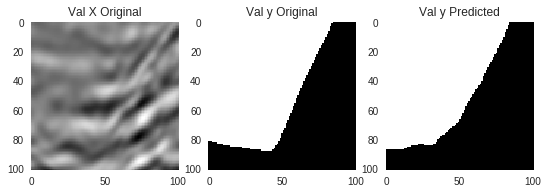

07/09/2018 07:13:36 - SaltNet - INFO - Epoch 2/100
07/09/2018 07:13:36 - SaltNet - INFO - --------------------
07/09/2018 07:13:36 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master bf8ac98] Pushing logs to git
 2 files changed, 52 insertions(+)
 create mode 100644 logs/SaltNet_2018_09_07_17h.log
Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 1.63 KiB | 1.63 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   67c4f78..bf8ac98  master -> master


07/09/2018 07:14:00 - SaltNet - INFO - Batch Loss: 0.1477, Epoch loss_1: 0.1249, Epoch loss_2: 0.0317, Batch IOU: 0.7344, Batch Acc: 0.9515 at iter 100, epoch 2, Time: 3m 13s


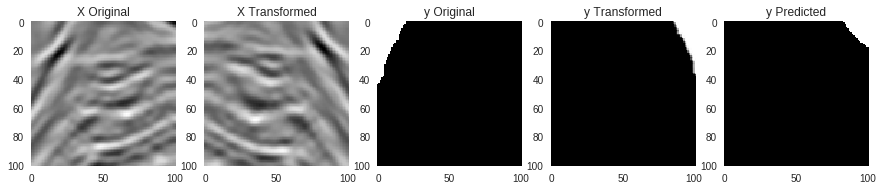

07/09/2018 07:15:24 - SaltNet - INFO - Batch Loss: 0.1698, Epoch loss_1: 0.1361, Epoch loss_2: 0.0324, Batch IOU: 0.8406, Batch Acc: 0.9819 at iter 150, epoch 2, Time: 4m 36s


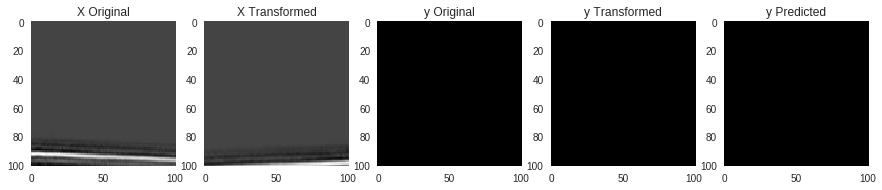

07/09/2018 07:16:30 - SaltNet - INFO - train Mean IOU: 0.7901, Mean Acc: 0.9393, Best Val IOU: 0.8128 at epoch 2
07/09/2018 07:16:42 - SaltNet - INFO - val Mean IOU: 0.8176, Mean Acc: 0.9550, Best Val IOU: 0.8128 at epoch 2
07/09/2018 07:16:42 - SaltNet - INFO - ['../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_2018_09_07_17_10_47.ckp-chunk-1-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_2018_09_07_17_10_47.ckp-chunk-2-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_2018_09_07_17_10_47.ckp-chunk-3-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_2018_09_07_17_10_47.ckp-chunk-4-Of-5', '../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_2018_09_07_17_10_47.ckp-chunk-5-Of-5']
07/09/2018 07:16:42 - SaltNet - INFO - Best Val Mean IOU so far: 0.817625


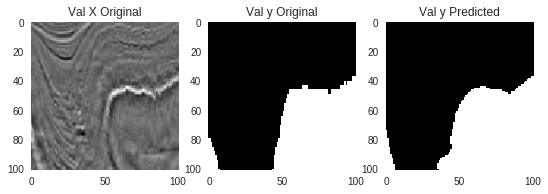

07/09/2018 07:16:43 - SaltNet - INFO - Epoch 3/100
07/09/2018 07:16:43 - SaltNet - INFO - --------------------
07/09/2018 07:16:59 - SaltNet - INFO - Batch Loss: 0.1441, Epoch loss_1: 0.1214, Epoch loss_2: 0.0278, Batch IOU: 0.8250, Batch Acc: 0.9708 at iter 200, epoch 3, Time: 6m 12s


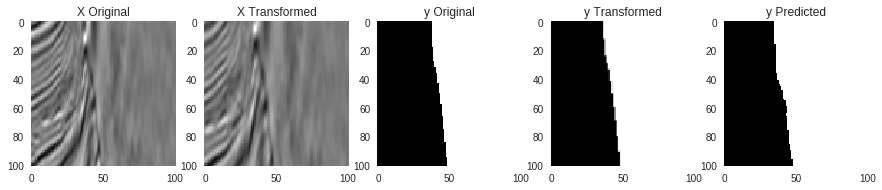

07/09/2018 07:18:22 - SaltNet - INFO - Batch Loss: 0.1536, Epoch loss_1: 0.1210, Epoch loss_2: 0.0319, Batch IOU: 0.8344, Batch Acc: 0.9502 at iter 250, epoch 3, Time: 7m 35s


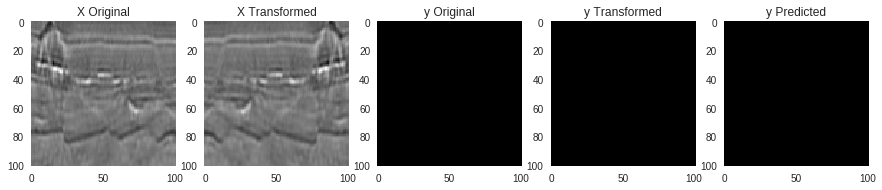

07/09/2018 07:19:20 - SaltNet - INFO - train Mean IOU: 0.7895, Mean Acc: 0.9408, Best Val IOU: 0.8176 at epoch 3
07/09/2018 07:19:32 - SaltNet - INFO - val Mean IOU: 0.8141, Mean Acc: 0.9530, Best Val IOU: 0.8176 at epoch 3
07/09/2018 07:19:32 - SaltNet - INFO - Epoch 4/100
07/09/2018 07:19:32 - SaltNet - INFO - --------------------
07/09/2018 07:19:32 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master ad4975c] Pushing logs to git
 1 file changed, 15 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 742 bytes | 742.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   bf8ac98..ad4975c  master -> master


07/09/2018 07:20:10 - SaltNet - INFO - Batch Loss: 0.1648, Epoch loss_1: 0.1329, Epoch loss_2: 0.0312, Batch IOU: 0.7469, Batch Acc: 0.9189 at iter 300, epoch 4, Time: 9m 23s


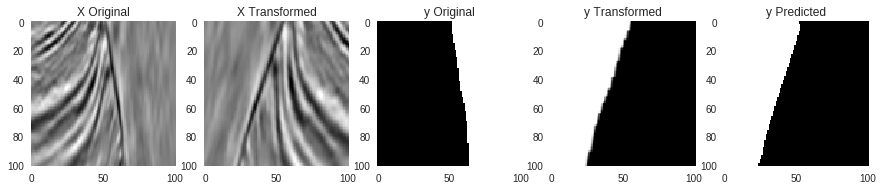

07/09/2018 07:21:34 - SaltNet - INFO - Batch Loss: 0.1478, Epoch loss_1: 0.1208, Epoch loss_2: 0.0307, Batch IOU: 0.7219, Batch Acc: 0.8942 at iter 350, epoch 4, Time: 10m 46s


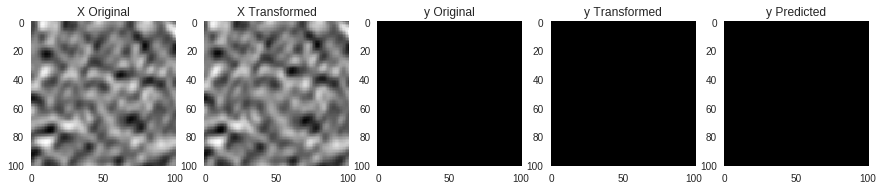

07/09/2018 07:22:23 - SaltNet - INFO - train Mean IOU: 0.7864, Mean Acc: 0.9388, Best Val IOU: 0.8176 at epoch 4
07/09/2018 07:22:35 - SaltNet - INFO - val Mean IOU: 0.8174, Mean Acc: 0.9553, Best Val IOU: 0.8176 at epoch 4
07/09/2018 07:22:35 - SaltNet - INFO - Epoch 5/100
07/09/2018 07:22:35 - SaltNet - INFO - --------------------
07/09/2018 07:23:08 - SaltNet - INFO - Batch Loss: 0.1746, Epoch loss_1: 0.1326, Epoch loss_2: 0.0331, Batch IOU: 0.8500, Batch Acc: 0.9666 at iter 400, epoch 5, Time: 12m 20s


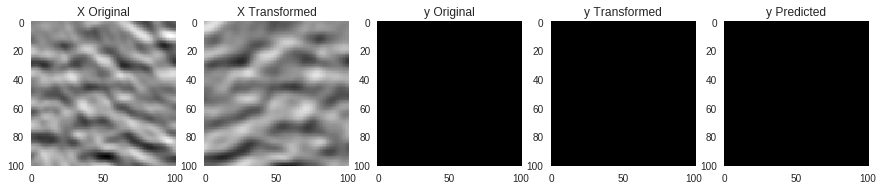

07/09/2018 07:24:31 - SaltNet - INFO - Batch Loss: 0.1529, Epoch loss_1: 0.1247, Epoch loss_2: 0.0318, Batch IOU: 0.7562, Batch Acc: 0.9663 at iter 450, epoch 5, Time: 13m 44s


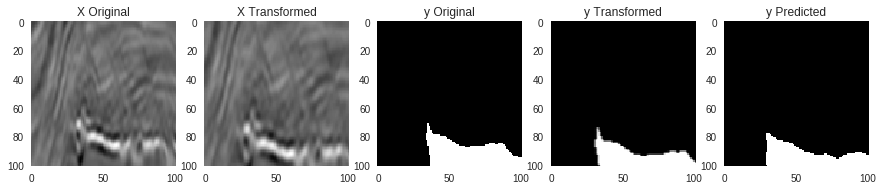

07/09/2018 07:25:12 - SaltNet - INFO - train Mean IOU: 0.7889, Mean Acc: 0.9403, Best Val IOU: 0.8176 at epoch 5
07/09/2018 07:25:24 - SaltNet - INFO - val Mean IOU: 0.8140, Mean Acc: 0.9538, Best Val IOU: 0.8176 at epoch 5
07/09/2018 07:25:24 - SaltNet - INFO - Epoch 6/100
07/09/2018 07:25:24 - SaltNet - INFO - --------------------
07/09/2018 07:25:24 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
[master faae46f] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 698 bytes | 698.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   ad4975c..faae46f  master -> master


07/09/2018 07:26:22 - SaltNet - INFO - Batch Loss: 0.1619, Epoch loss_1: 0.1221, Epoch loss_2: 0.0333, Batch IOU: 0.7688, Batch Acc: 0.9242 at iter 500, epoch 6, Time: 15m 34s


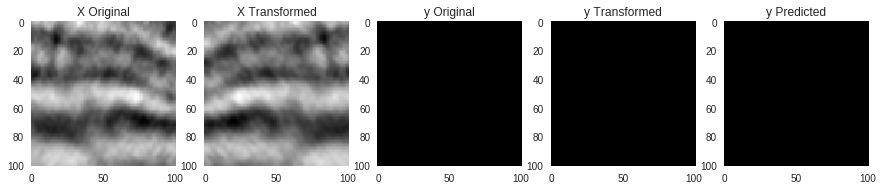

In [ ]:
# fine tuning
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
if torch.cuda.is_available():
  saltnet.cuda()
model_file_suffix = "../salt_net/Unet_bce_loss_lovasz_loss_2018_09_05_23_54_40.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
optimizer.load_state_dict(model_state_dict['optimizer'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler.load_state_dict(model_state_dict['scheduler'])

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_remove_low_salt_{get_current_time_as_fname()}.ckp'
#model_save_name = None
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=50, save_model_every=20, save_log_every=2, log=log, loss2_weight=0.1)

In [55]:
cd ../salt_net

/content/salt_net


In [58]:
!git status

On branch master
Your branch is up-to-date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	logs/SaltNet_2018_09_07_16h.log

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
## Train a new model
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_finetune_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=250, print_every=50, save_model_every=20, save_log_every=2, log=log)

## Load Trained Model

In [ ]:
loaded_model = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)

Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling


In [ ]:
ls

logs/
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-4-Of-5
Unet_bce_loss_bilin

In [ ]:
model_file_suffix = "Unet_bce_loss_lovasz_loss_finetune_2018_09_06_11_59_40.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
loaded_model.load_state_dict(model_state_dict['model'])

### Make Predictions on validation set

### Set model to evaluation mode

In [ ]:
loaded_model.eval()
assert loaded_model.training == False

In [ ]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128), batch_size=16)

In [ ]:
if torch.cuda.is_available():
    loaded_model.cuda()

In [ ]:
y_val_pred = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred.append(loaded_model(X_val_batch))
y_val_pred = torch.cat(y_val_pred)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img, out_size=128), batch_size=16)
y_train_pred = []

with torch.no_grad():
    for X_train_batch, y_train_batch, depth_train_batch, X_train_id_batch in train_dataLoader:
        y_train_pred.append(loaded_model(X_train_batch))
y_train_pred = torch.cat(y_train_pred)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Image ID: 797


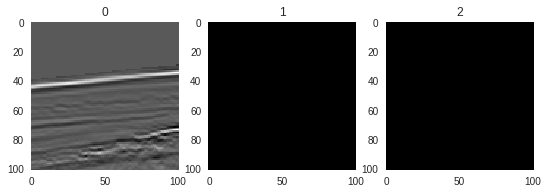

Image ID: 794


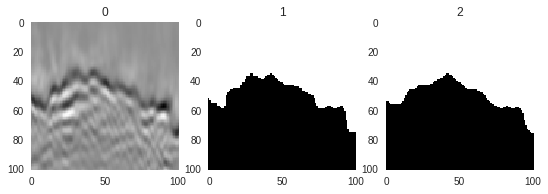

Image ID: 787


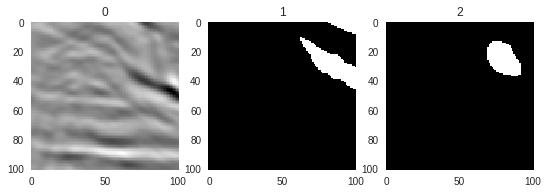

Image ID: 797


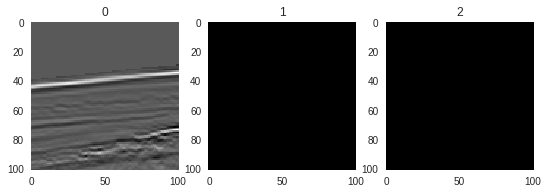

Image ID: 789


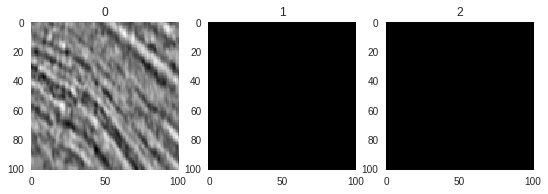

Image ID: 796


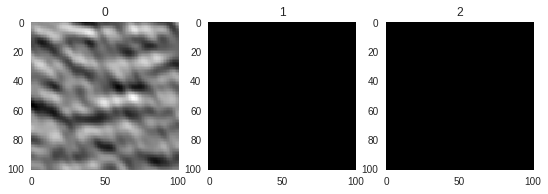

Image ID: 796


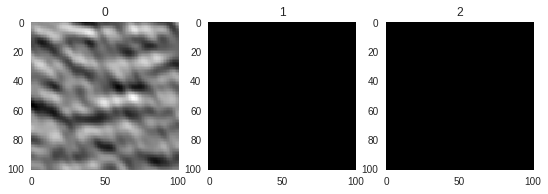

Image ID: 789


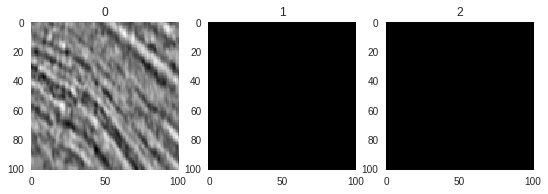

Image ID: 796


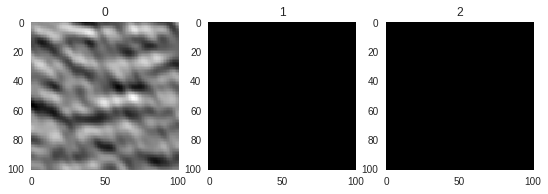

Image ID: 784


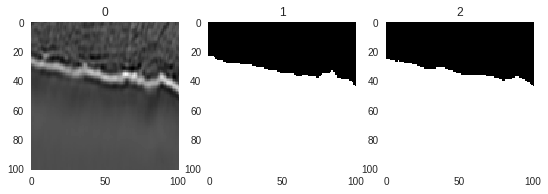

In [ ]:
for i in range(10):
    rand_id = np.random.choice(X_val_id_batch)
    print(f'Image ID: {rand_id}')
    val_img = X_val[rand_id]/255
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred.ge(MASK_CUTOFF)[rand_id]
    plot_img_mask_pred([val_img, val_mask, val_mask_pred], range(3), img_per_line=3)

Image ID: 3199


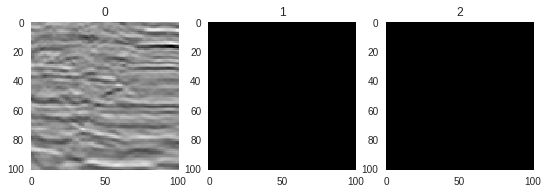

Image ID: 3192


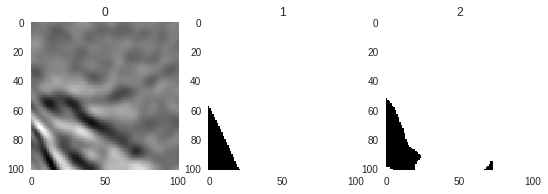

Image ID: 3185


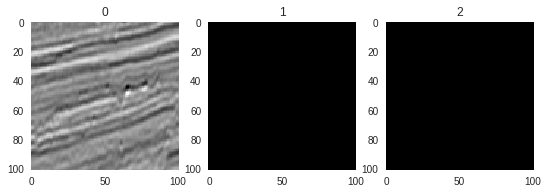

Image ID: 3192


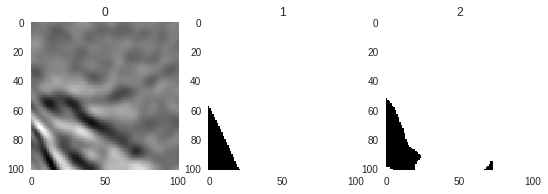

Image ID: 3188


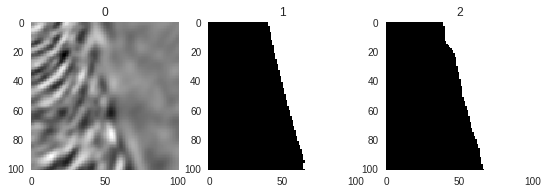

Image ID: 3193


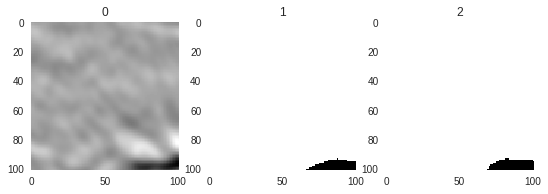

Image ID: 3192


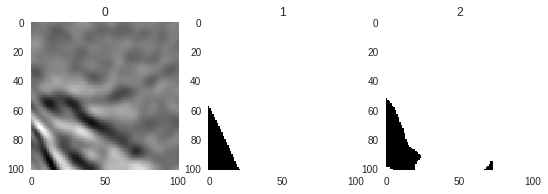

Image ID: 3192


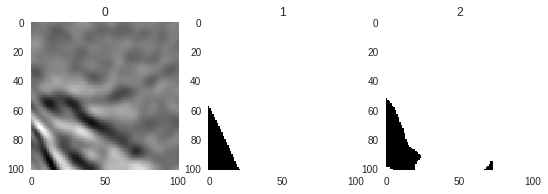

Image ID: 3188


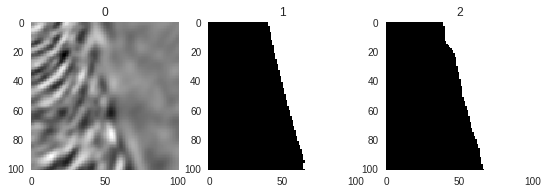

Image ID: 3192


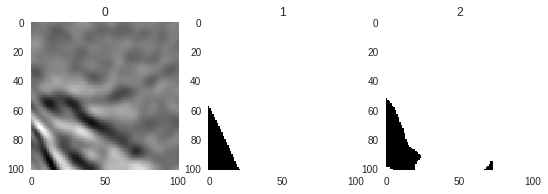

In [ ]:
for i in range(10):
    rand_id = np.random.choice(X_train_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_train[rand_id]/255
    mask = y_train[rand_id]
    mask_pred = y_train_pred.ge(MASK_CUTOFF)[rand_id]
    plot_img_mask_pred([img, mask, mask_pred], range(3), img_per_line=3)

In [ ]:
ZERO_MASK_CUTOFF = 20
MASK_CUTOFF = 0.

In [ ]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

06/09/2018 05:32:56 - SaltNet - INFO - IOU score before: 0.8192499999999999, IOU Score after:0.81825


In [ ]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(-0.3), y_val.squeeze())

06/09/2018 06:52:24 - SaltNet - INFO - IOU score before: 0.8194999999999999, IOU Score after:0.8194999999999999


In [ ]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze()), y_val.squeeze()))

In [ ]:
range(0, 300, 10)[np.argmax(results)]

0

In [ ]:
results

In [ ]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

06/09/2018 05:33:54 - SaltNet - INFO - IOU score before: 0.8192499999999999, IOU Score after:0.81825


In [ ]:
y_train_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze())

06/09/2018 05:34:01 - SaltNet - INFO - IOU score before: 0.8289687499999999, IOU Score after:0.8294687500000001


In [ ]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze()), y_train.squeeze()))

In [ ]:
range(0, 3000, 10)[np.argmax(results)]

20

## Make predictions on test set

In [ ]:
#test_dataLoader = DataLoader(SaltDataset(np_test[:10], None, depth_test, X_train_mean_img), batch_size=4)
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128), batch_size=16)

In [ ]:
y_test_pred_raw = []
with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_raw.append(loaded_model(X_test_batch))
y_test_pred = torch.cat(y_test_pred_raw)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


### Show segmentation masks for a few images

In [ ]:
for i in range(10):
    rand_id = np.random.choice(X_test_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_test[rand_id]/255
    mask_pred = y_test_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask_pred], range(2))

### Adjust predictions

In [ ]:
 ZERO_MASK_CUTOFF = 0.

In [ ]:
y_test_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_test, y_test_pred.gt(MASK_CUTOFF))

### Encode predictions using RLE(Run Length Encoding) method

In [ ]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [ ]:
y_test_pred_adj.shape

(18000, 101, 101)

In [ ]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'], data=y_test_pred_rle).reset_index()

In [ ]:
df_test_rle.columns = ['id', 'rle_mask']

In [ ]:
df_test_rle[df_test_rle.rle_mask==''].shape

(7807, 2)

In [ ]:
df_test_rle.shape

(18000, 2)

In [ ]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)

In [ ]:
ls

logs/
submission_2018_09_06_16_20_54.csv
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.c

In [ ]:
from google.colab import files


In [ ]:
files.download('submission_2018_09_06_16_20_54.csv') 

In [ ]:
y_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(MASK_CUTOFF))

In [ ]:
df_test_rle = pd.DataFrame(depth_val, columns=['z'])

In [ ]:
df_test_rle['num_salt_pix'] = y_pred_adj.sum((1,2))

In [ ]:
df_test_rle.head()

,z,num_salt_pix
id,,
25db231ea0,581,3773
dfd3138198,373,0
2425501bf4,788,0
fbb8eba26d,743,0
bea9b0571b,366,9422


In [ ]:
exp_black_mask_pct = [0.822, 0.755, 0.707, 0.568, 0.464, 0.378, 0.289, 0.285, 0.317, 0.25, 0.354, 0.255, 0.339, 0.357, 0.385, 0.442, 0.65, 0.58, 0.778]

In [ ]:
df_test_z_grp

,total,black_mask,black_mask_pct
z_bin,,,
50,16.0,15.0,0.937500
100,31.0,21.0,0.677419
150,28.0,24.0,0.857143
200,47.0,28.0,0.595745
250,34.0,17.0,0.500000
300,45.0,15.0,0.333333
350,55.0,21.0,0.381818
400,48.0,20.0,0.416667
450,75.0,26.0,0.346667


In [ ]:
len(exp_black_mask_pct)

19

In [ ]:
df_test_rle['z_bin'] = df_test_rle.z.floordiv(50).mul(50)
df_test_rle['black_mask'] = df_test_rle.num_salt_pix==0
df_test_z_grp = (
    df_test_rle.groupby('z_bin')
    .apply(lambda x: pd.Series([len(x),
                               x.black_mask.sum(),
                               x.black_mask.sum()/len(x)],
                               ['total','black_mask', 'black_mask_pct'])
          )
    #.sort_values('black_mask_pct', ascending=False)
)
df_test_z_grp['exp_black_mask_pct'] = exp_black_mask_pct[:-1]

In [ ]:
df_test_rle.head()

,z,num_salt_pix,z_bin,black_mask
id,,,,
25db231ea0,581,3773,550,False
dfd3138198,373,0,350,True
2425501bf4,788,0,750,True
fbb8eba26d,743,0,700,True
bea9b0571b,366,9422,350,False


In [ ]:
df_test_z_grp

,total,black_mask,black_mask_pct,exp_black_mask_pct
z_bin,,,,
50,16.0,15.0,0.937500,0.822
100,31.0,21.0,0.677419,0.755
150,28.0,24.0,0.857143,0.707
200,47.0,28.0,0.595745,0.568
250,34.0,17.0,0.500000,0.464
300,45.0,15.0,0.333333,0.378
350,55.0,21.0,0.381818,0.289
400,48.0,20.0,0.416667,0.285
450,75.0,26.0,0.346667,0.317
